# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, train_loop, test_loop
from common_utils import preprocess_dataset, split_dataset

In [3]:
print("torch.cuda.is_available: ", torch.cuda.is_available())
print("torch.cuda.device_count ", torch.cuda.device_count())
print("torch.cuda.current_device ", torch.cuda.current_device())
print("torch.cuda.device " , torch.cuda.device(0))
print("torch.cuda.get_device_name ", torch.cuda.get_device_name(0))

torch.cuda.is_available:  True
torch.cuda.device_count  1
torch.cuda.current_device  0
torch.cuda.device  <torch.cuda.device object at 0x000001A7229E6390>
torch.cuda.get_device_name  NVIDIA GeForce RTX 3050 Laptop GPU


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [4]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    cv_fold = 5

    # Store preprocessed training data for different batch sizes
    # Store preprocessed validation data for different batch sizes
    # Store labels for training data for different batch sizes
    # Store labels for validation data for different batch sizes
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}

    # Preprocess the training data
    standard_scaler = preprocessing.StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)

    kfold = KFold(n_splits=cv_fold, shuffle=True, random_state=0)

    for batch_size in parameters:

        # Store preprocessed training data for each fold
        # Store preprocessed validation data for each fold
        # Store labels for training data for each fold
        # Store labels for validation data for each fold
        X_train_scaled_folds, X_val_scaled_folds, y_train_folds, y_val_folds = [], [], [], []

        for train_index, val_index in kfold.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
            X_test_fold, y_test_fold = X_train[val_index], y_train[val_index]

            X_train_scaled_folds.append(X_train_fold)
            X_val_scaled_folds.append(X_test_fold)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_test_fold)

        # Store data for the current batch size
        X_train_scaled_dict[batch_size] = X_train_scaled_folds
        X_val_scaled_dict[batch_size] = X_val_scaled_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

In [ ]:
# Prepare dataset
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train, y_train, X_test, y_test = split_dataset(df, ['filename','label'], test_size=0.3, random_state=0)
X_train = pd.concat([X_train, X_test])
y_train = np.concatenate((y_train, y_test), axis=0)

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes,
                                                                                                     X_train.to_numpy(),
                                                                                                     y_train)

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
# Import necessary libraries
from statistics import mean

# Set hyperparameters
drop_out = 0.2
no_features = 77
no_hidden = 128
no_labels = 1
lr = 0.001
num_epochs = 20  # Number of training epochs

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparam):
    # Initialize dictionaries to store cross-validation results
    cross_validation_accuracies = {}
    cross_validation_times = {}

    # Loop through different batch sizes
    for batch_size in batch_sizes:
        # Get training and validation data for the current batch size
        x_train = X_train_scaled_dict[batch_size]
        x_val = X_val_scaled_dict[batch_size]
        y_train = y_train_dict[batch_size]
        y_val = y_val_dict[batch_size]

        fold_accuracies = []  # Store accuracies for each fold
        timing = []  # Store time taken for each fold

        # Iterate over folds
        for fold in range(len(x_train)):
            # Initialize the model, optimizer, and loss function
            model = MLP(no_features=no_features, no_hidden=no_hidden, no_labels=no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.BCELoss()

            # Create custom datasets and data loaders
            train_dataset = CustomDataset(x_train[fold], y_train[fold])
            val_dataset = CustomDataset(x_val[fold], y_val[fold])

            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            for epoch in range(num_epochs):
                if epoch == num_epochs - 1:
                    start_time = time.time()
                print(f"Epoch {epoch + 1}\n--------------------------------")
                train_loop(train_dataloader, model, loss_fn, optimizer)

                if epoch == num_epochs - 1:
                    end_time = time.time()
                    timing.append(end_time - start_time)

            loss, accuracy = test_loop(val_dataloader, model, loss_fn)
            fold_accuracies.append(accuracy)

        # Calculate the mean accuracy and mean time taken
        mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
        mean_time = mean(timing)

        # Store results in dictionaries
        cross_validation_accuracies[batch_size] = mean_accuracy
        cross_validation_times[batch_size] = mean_time

    return cross_validation_accuracies, cross_validation_times

# Specify batch sizes to evaluate
batch_sizes = [128, 256, 512, 1024]

# Call the function to find optimal hyperparameters
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict,
                                                                                  X_val_scaled_dict, y_train_dict,
                                                                                  y_val_dict, batch_sizes, 'batch_size')

Epoch 1
--------------------------------
loss: 0.695822  [  128/ 9645]
Train Error: 
 Accuracy: 55.2%, Avg loss: 0.686069 

Epoch 2
--------------------------------
loss: 0.661246  [  128/ 9645]
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.666637 

Epoch 3
--------------------------------
loss: 0.657529  [  128/ 9645]
Train Error: 
 Accuracy: 61.5%, Avg loss: 0.650851 

Epoch 4
--------------------------------
loss: 0.644450  [  128/ 9645]
Train Error: 
 Accuracy: 63.8%, Avg loss: 0.633376 

Epoch 5
--------------------------------
loss: 0.628327  [  128/ 9645]
Train Error: 
 Accuracy: 65.9%, Avg loss: 0.614576 

Epoch 6
--------------------------------
loss: 0.611528  [  128/ 9645]
Train Error: 
 Accuracy: 67.7%, Avg loss: 0.597183 

Epoch 7
--------------------------------
loss: 0.573265  [  128/ 9645]
Train Error: 
 Accuracy: 68.9%, Avg loss: 0.579313 

Epoch 8
--------------------------------
loss: 0.585145  [  128/ 9645]
Train Error: 
 Accuracy: 70.7%, Avg loss: 0.562989 

Epoch 9


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

Mean Cross-Validation Accuracy for Batch Size 128: 0.7154
Mean Cross-Validation Accuracy for Batch Size 256: 0.7055
Mean Cross-Validation Accuracy for Batch Size 512: 0.6857
Mean Cross-Validation Accuracy for Batch Size 1024: 0.6660


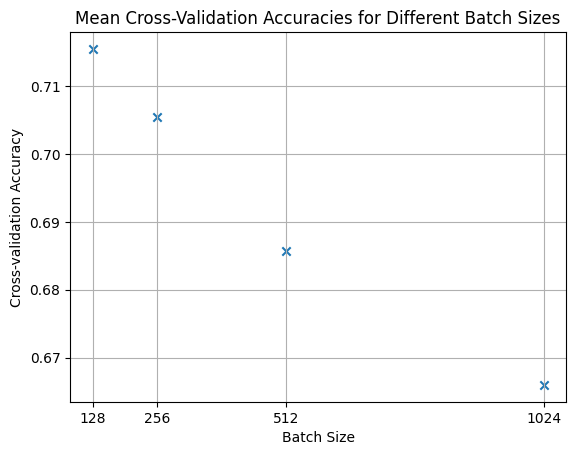

In [6]:
# YOUR CODE HERE
mean_accuracies = []
for batch_size, mean_accuracy in cross_validation_accuracies.items():
    print(f"Mean Cross-Validation Accuracy for Batch Size {batch_size}: {mean_accuracy:.4f}")
    mean_accuracies.append(mean_accuracy)

# Create a scatterplot
plt.figure(1)
plt.scatter(batch_sizes, mean_accuracies, label='Mean Cross-Validation Accuracy', marker = 'x')
plt.title('Mean Cross-Validation Accuracies for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.xticks(batch_sizes)
plt.ylabel('Cross-validation Accuracy')
plt.grid(True)

# Show the plot
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [7]:
last_epoch_mean_times = {}

# Populate the dictionary with the last epoch times for each batch size
for batch_size, mean_time in cross_validation_times.items():
    last_epoch_mean_times[batch_size] = mean_time

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(last_epoch_mean_times.items()), columns=['Batch Size', 'Mean time to train last epoch'])
df

,Batch Size,Mean time to train last epoch
0,128,0.231153
1,256,0.162060
2,512,0.150614
3,1024,0.148269


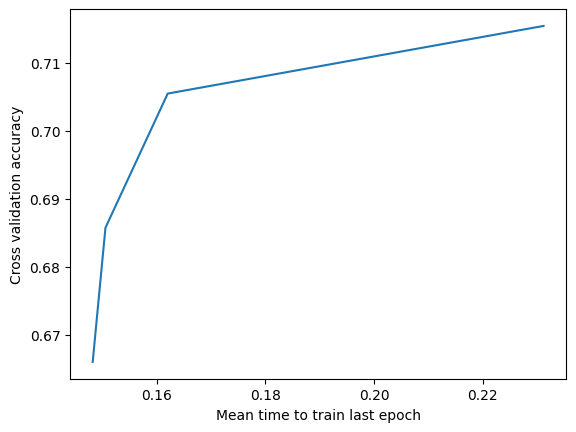

In [8]:
plt.plot(df["Mean time to train last epoch"], cross_validation_accuracies.values())
plt.xlabel("Mean time to train last epoch")
plt.ylabel("Cross validation accuracy")
plt.show()

`optimal_batch_size = 256`

**Reason**

In terms of maximising training time vs cross-validation accuracy, I would select `optimal_batch_size=256` because it significantly reduces training time while not having a significant drop in cross-validation accuracy <1%, similar to the logic used in the `Elbow method` for ascertaining the ideal number of centroids for k-means clustering. 

Evidently, as we progress from a batch size of `128` to `256`, we observe only a minor decline in cross-validation accuracy, all while notably reducing the training time. Nonetheless, when transitioning from a batch size of `256` to `512`, the decrease in cross-validation accuracy is considerably more substantial compared to the amelioration in training time. Furthermore, any subsequent augmentation in batch size fails to deliver significant enhancements in training time. 

Therefore, I have opted for a `batch size of 256` as the most suitable choice.

Table Comparison:
| Batch-size | Accuracy | Mean time to train Last Epoch |
|------------|----------|-------------------------------|
| 128        | 0.7154   | 0.231153                      |
| 256        | 0.7055   | 0.162060                      |
| 512        | 0.6857   | 0.150614                      |
| 1024       | 0.6660   | 0.148269                      |